# Visual Document NER

In [1]:
secret = ""
license = ""
version = secret.split("-")[0]
spark_ocr_jar_path = "../../target/scala-2.12/"
AWS_ACCESS_KEY_ID = ""
AWS_SECRET_ACCESS_KEY = ""

import os
#os.environ['JSL_OCR_LICENSE'] = license
#os.environ["AWS_ACCESS_KEY_ID"] = AWS_ACCESS_KEY_ID
#os.environ["AWS_SECRET_ACCESS_KEY"] = AWS_SECRET_ACCESS_KEY

In [2]:
import pyspark
import sparkocr
import json
import os

from pyspark.sql import SparkSession
from pyspark.ml import PipelineModel
import pyspark.sql.functions as f

from sparkocr.transformers import *
from sparkocr.utils import display_images
from sparkocr.enums import *

### Initialize Spark session

In [ ]:
from sparkocr import start
from pyspark import SparkConf

spark = start(secret=secret, jar_path=spark_ocr_jar_path)
spark

## Load test images

In [4]:
import pkg_resources
test_image_path = pkg_resources.resource_filename('sparkocr', 'resources/ocr/forms/form1.jpg')
bin_df = spark.read.format("binaryFile").load(test_image_path)
bin_df.show()

+--------------------+-------------------+------+--------------------+
|                path|   modificationTime|length|             content|
+--------------------+-------------------+------+--------------------+
|file:/Users/nmeln...|2023-07-18 08:30:46|421333|[FF D8 FF E0 00 1...|
+--------------------+-------------------+------+--------------------+



## Display images


    Image #0:
    Origin: file:/Users/nmelnik/.local/share/virtualenvs/OcrMissedPages-W3gpzUuJ/lib/python3.7/site-packages/sparkocr/resources/ocr/forms/form1.jpg
    Resolution: 150 dpi
    Width: 1240 px
    Height: 1755 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


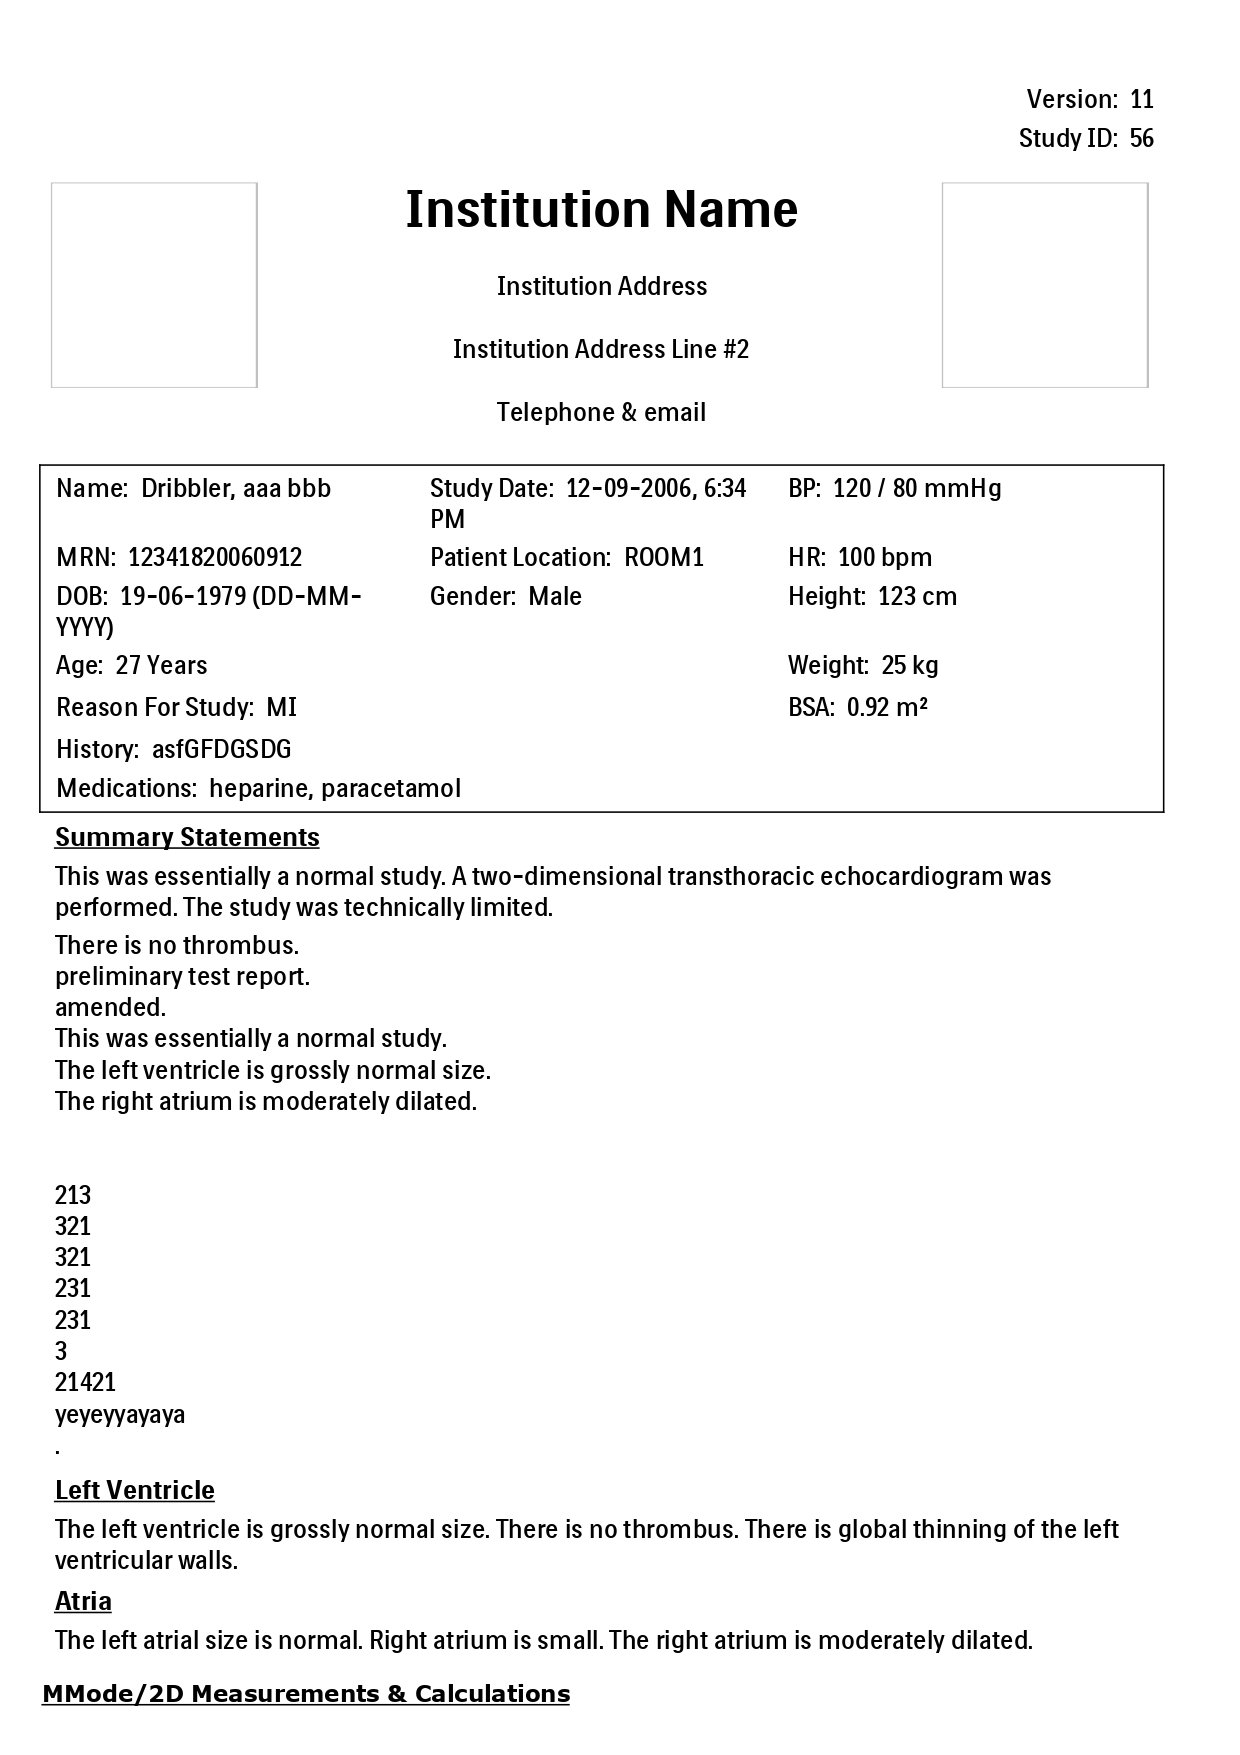

In [5]:
image_df = BinaryToImage().transform(bin_df)
display_images(image_df)

### Define pipeline

In [6]:
binary_to_image = BinaryToImage()\
    .setOutputCol("image") \
    .setImageType(ImageType.TYPE_3BYTE_BGR)

img_to_hocr = ImageToHocr()\
    .setInputCol("image")\
    .setOutputCol("hocr")\
    .setIgnoreResolution(False)\
    .setOcrParams(["preserve_interword_spaces=0"])

tokenizer = HocrTokenizer()\
    .setInputCol("hocr")\
    .setOutputCol("tokens")

doc_ner = VisualDocumentNer()\
    .pretrained("lilt_roberta_funsd_v1", "en", "clinical/ocr")\
    .setInputCols(["tokens", "image"])\
    .setOutputCol("entities")

draw = ImageDrawAnnotations() \
    .setInputCol("image") \
    .setInputChunksCol("entities") \
    .setOutputCol("image_with_annotations") \
    .setFontSize(10) \
    .setLineWidth(4)\
    .setRectColor(Color.red)

# OCR pipeline
pipeline = PipelineModel(stages=[
    binary_to_image,
    img_to_hocr,
    tokenizer,
    doc_ner,
    draw
])

lilt_roberta_funsd_v1 download started this may take some time.
Approximate size to download 419.6 MB


## Call pipeline

In [7]:
results = pipeline.transform(bin_df).cache()

## Show results

In [8]:
## since pyspark2.3 doesn't have element_at, 'getItem' is involked
path_array = f.split(results['path'], '/')

# from pyspark2.4
# results.withColumn("filename", f.element_at(f.split("path", "/"), -1)) \

results.withColumn('filename', path_array.getItem(f.size(path_array)- 1)) \
    .withColumn("exploded_entities", f.explode("entities")) \
    .select("filename", "exploded_entities") \
    .show(truncate=False)
            

/Users/nmelnik/.local/share/virtualenvs/OcrMissedPages-W3gpzUuJ/lib/python3.7/site-packages/pyspark/sql/column.py:326: FutureWarning: A column as 'key' in getItem is deprecated as of Spark 3.0, and will not be supported in the future release. Use `column[key]` or `column.key` syntax instead.
  FutureWarning


+---------+-------------------------------------------------------------------------------------------------------------------------------------------------------+
|filename |exploded_entities                                                                                                                                      |
+---------+-------------------------------------------------------------------------------------------------------------------------------------------------------+
|form1.jpg|{named_entity, 0, 7, b-question, {x -> 1027, y -> 89, height -> 19, confidence -> 106, token -> version, ocr_confidence -> 96, width -> 90}, []}       |
|form1.jpg|{named_entity, 7, 8, i-question, {x -> 1027, y -> 89, height -> 19, confidence -> 67, token -> :, ocr_confidence -> 96, width -> 90}, []}              |
|form1.jpg|{named_entity, 10, 15, b-question, {x -> 1020, y -> 128, height -> 23, confidence -> 95, token -> study, ocr_confidence -> 96, width -> 61}, []}       |
|form1.jpg|{name


    Image #0:
    Origin: file:/Users/nmelnik/.local/share/virtualenvs/OcrMissedPages-W3gpzUuJ/lib/python3.7/site-packages/sparkocr/resources/ocr/forms/form1.jpg
    Resolution: 0 dpi
    Width: 1240 px
    Height: 1755 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


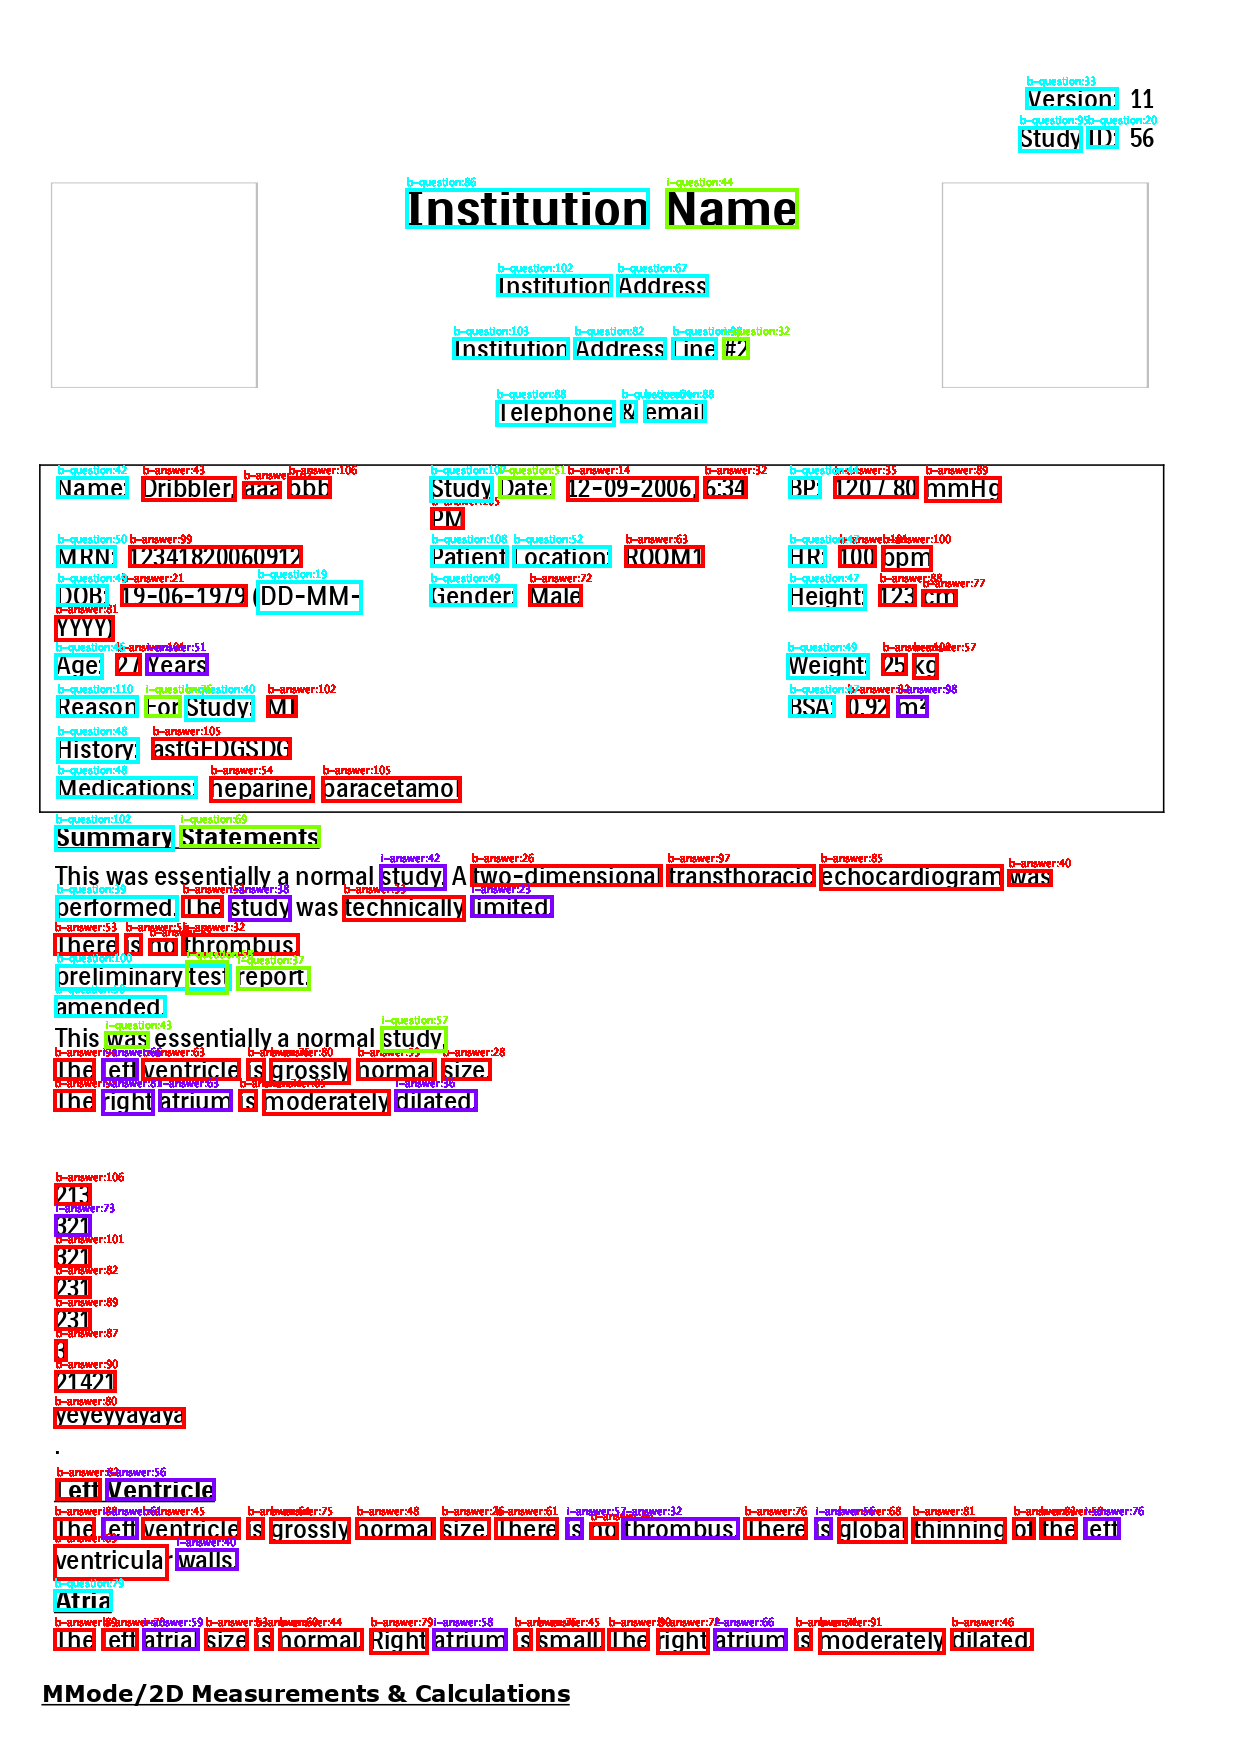

In [9]:
display_images(results, "image_with_annotations", width=1000)

## Customize labels

lilt_roberta_funsd_v1 download started this may take some time.
Approximate size to download 419.6 MB

    Image #0:
    Origin: file:/Users/nmelnik/.local/share/virtualenvs/OcrMissedPages-W3gpzUuJ/lib/python3.7/site-packages/sparkocr/resources/ocr/forms/form1.jpg
    Resolution: 0 dpi
    Width: 1240 px
    Height: 1755 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


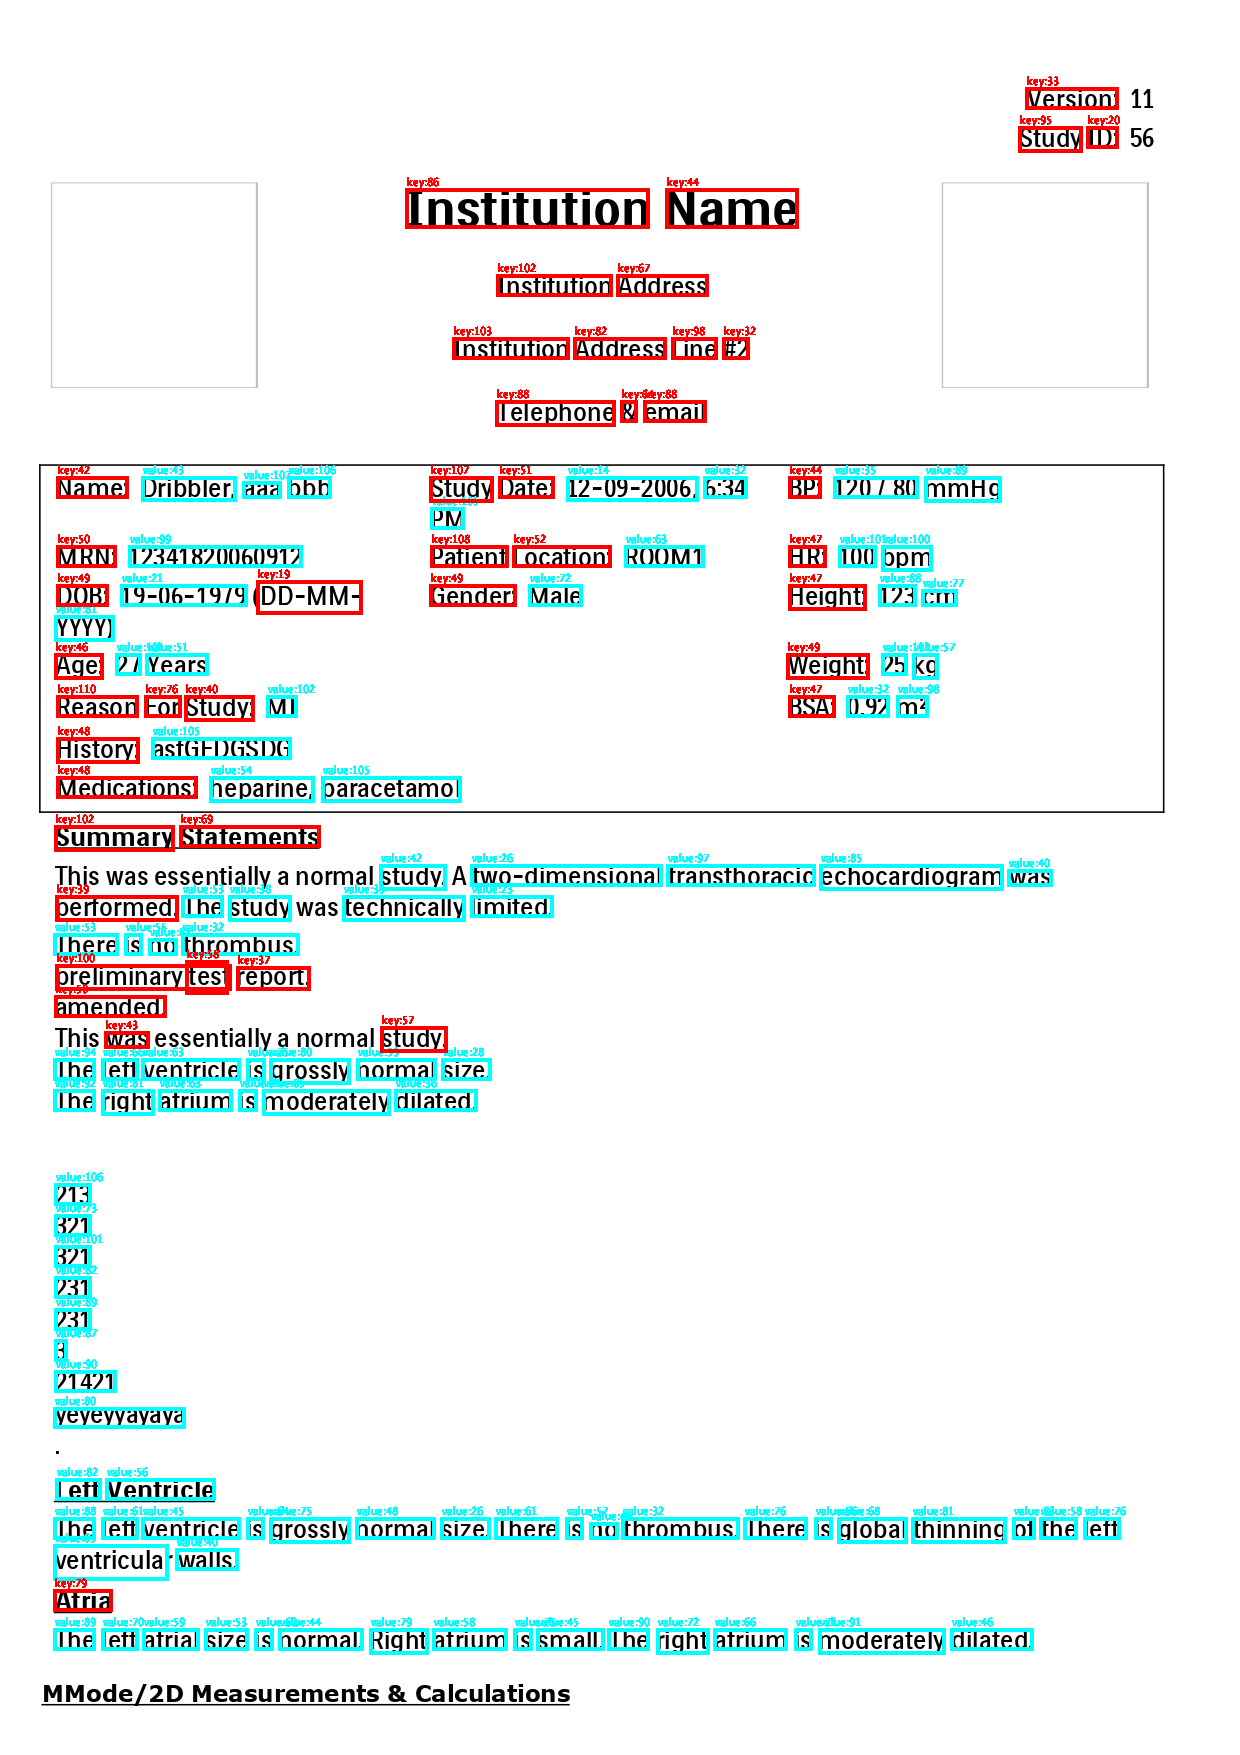

In [10]:
binary_to_image_ = BinaryToImage()\
    .setOutputCol("image") \
    .setImageType(ImageType.TYPE_3BYTE_BGR)

img_to_hocr_ = ImageToHocr()\
    .setInputCol("image")\
    .setOutputCol("hocr")\
    .setIgnoreResolution(False)\
    .setOcrParams(["preserve_interword_spaces=0"])

tokenizer = HocrTokenizer()\
    .setInputCol("hocr")\
    .setOutputCol("tokens")

doc_ner_cust = VisualDocumentNer()\
    .pretrained("lilt_roberta_funsd_v1", "en", "clinical/ocr")\
    .setInputCols(["tokens", "image"])\
    .setOutputCol("entities")\
    .setLabels(["other",
                "header",
                "header",
                "key",
                "key",
                "value",
                "value"])\
    .setWhiteList(["header",
                   "key",
                   "value"])

draw_ = ImageDrawAnnotations() \
    .setInputCol("image") \
    .setInputChunksCol("entities") \
    .setOutputCol("image_with_annotations") \
    .setFontSize(10) \
    .setLineWidth(4)\
    .setRectColor(Color.red)


# OCR pipeline
pipeline_cust = PipelineModel(stages=[
    binary_to_image_,
    img_to_hocr_,
    tokenizer,
    doc_ner_cust,
    draw_
])

results_cust = pipeline_cust.transform(bin_df).cache()
display_images(results_cust, "image_with_annotations", width=1000)